In [2]:
%run 0_result_analysis_functions.ipynb

In [3]:
# Import catalog with SimstackWrapper

# -agn
combined_pickle_filename = "uVista_DR2_Ahat_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4p0_X_4_foregnd_layers_"
prefix='Ahat__A_gt_n35p5_'

combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", combined_pickle_filename)
underscore_suffix = "" # "__"
path_ini_file = os.path.join(combined_pickle_path+underscore_suffix, "uvista.ini")
path_pickle_file = os.path.join(combined_pickle_path+underscore_suffix, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [4]:
simstack_maps_object = SimstackWrapper(path_ini_file, save_automatically=False, read_maps=True, read_catalog=False)

In [5]:
# Import saved stacking results
simstack_object = SimstackToolbox.import_saved_pickles(path_pickle_file)

In [6]:
# Pass saved results into SimstackResults
simstack_object = SimstackResults(simstack_object)

In [7]:
# Pass saved results into SimstackPlots
simstack_object = SimstackPlots(simstack_object)

In [8]:
simstack_object.config_dict['catalog']['classification'].keys()

dict_keys(['redshift', 'stellar_mass', 'agn_fraction', 'split_params'])

In [9]:
fluxes_dict = parse_fluxes(simstack_object)

In [10]:
np.shape(fluxes_dict['flux'])

(7, 8, 4, 5, 2)

In [11]:
# SLOW!
sed_dict = get_fast_sed_dict(simstack_object, fluxes_dict, simstack_catalog_object)

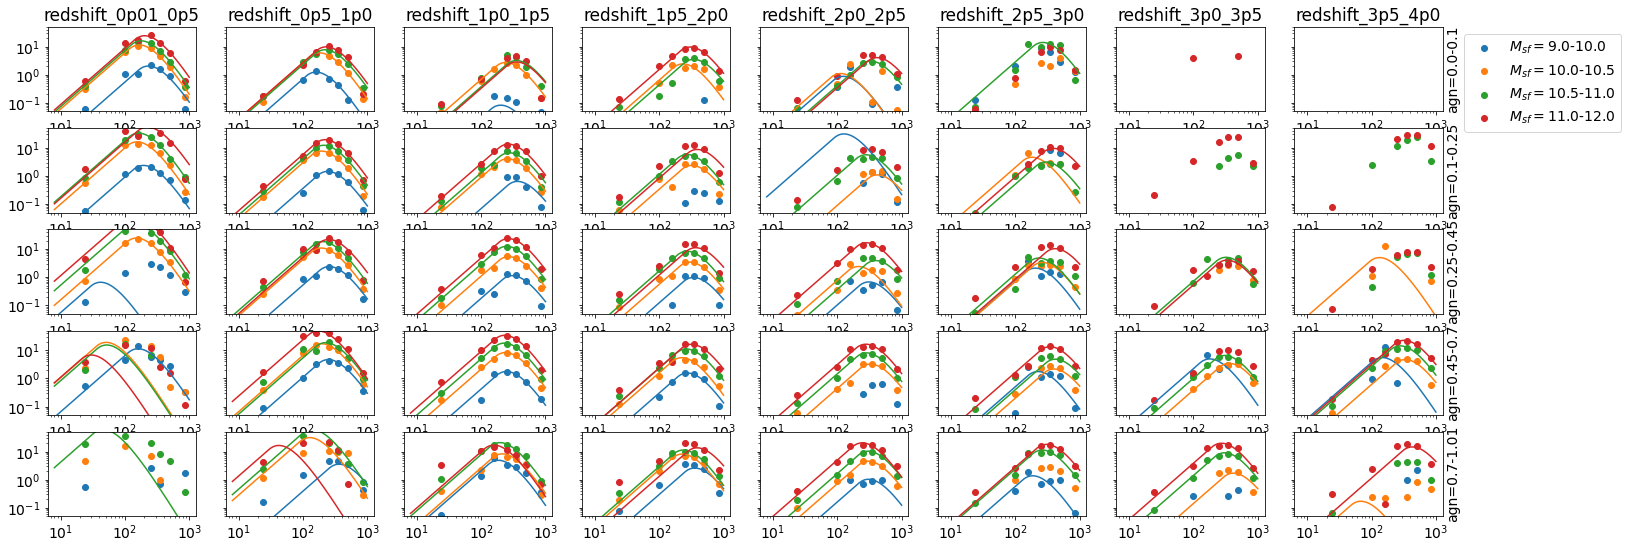

In [12]:
plot_pops(simstack_object,sed_dict=sed_dict)

In [14]:
idx_Ahat_zero = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] == 0
idx_Ahat_not_zero = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] > 0

In [16]:
print(np.sum(idx_Ahat_zero)/len(idx_Ahat_zero))
print(np.sum(idx_Ahat_not_zero)/len(idx_Ahat_zero))

0.34123492945575007
0.6587650705442499


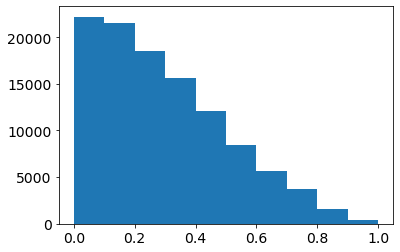

In [21]:
plt.hist(simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'][idx_Ahat_not_zero]);

# Fit model to stacked Fluxes

In [22]:
As_sf = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_0' not in i])
Ts_sf = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_0' not in i])

Ms_sf = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_0' not in i])
Zs_sf = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_0' not in i])

In [23]:
As_qt = np.array([sed_dict['sed_params'][i]['A'].value for i in sed_dict['sed_params'] if 'params_1' not in i])
Ts_qt = np.array([(1+sed_dict['redshift'][i])*sed_dict['sed_params'][i]['T_observed'].value for i in sed_dict['sed_params'] if 'params_1' not in i])

Ms_qt = np.array([sed_dict['stellar_mass'][i] for i in sed_dict['stellar_mass'] if 'params_1' not in i])
Zs_qt = np.array([sed_dict['redshift'][i] for i in sed_dict['redshift'] if 'params_1' not in i])

In [24]:
AGNs_sf = np.array([sed_dict['agn_fraction'][i] for i in sed_dict['agn_fraction'] if 'params_0' not in i])
AGNs_qt = np.array([sed_dict['agn_fraction'][i] for i in sed_dict['agn_fraction'] if 'params_1' not in i])

In [25]:
idx_keep_sf = (Zs_sf > 0.1) & (As_sf > -35.5) & (Ts_sf < 65)
cube_sf = np.array([Zs_sf[idx_keep_sf],Ms_sf[idx_keep_sf],AGNs_sf[idx_keep_sf]])
idx_keep_qt = (Zs_qt > 0.1) & (As_qt > -35.5) & (Ts_qt < 65)
cube_qt = np.array([Zs_qt[idx_keep_qt],Ms_qt[idx_keep_qt],AGNs_qt[idx_keep_qt]])

In [26]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_sf = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_sf,),
                     kws={'y': As_sf[idx_keep_sf]},
                     nan_policy='propagate')
cov_Tdust_sf = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_sf,),
                     kws={'y': Ts_sf[idx_keep_sf]},
                     nan_policy='propagate')

In [27]:
# Define Fit Parameters
fit_params_Adust = Parameters()
fit_params_Adust.add('offset', value=1e-3 * np.random.randn())
fit_params_Tdust = Parameters()
fit_params_Tdust.add('offset', value=1e-3 * np.random.randn())

catalog_keys = []
for key, val in simstack_object.config_dict['catalog']['classification'].items():
    if 'redshift' in key:
        value = 1.4
    else:
        value=1e-3 * np.random.randn()
        
    if 'split_params' not in key:
        fit_params_Adust.add('slope_'+key, value=value)
        fit_params_Tdust.add('slope_'+key, value=value)
        catalog_keys.append(val['id'])
    
cov_Adust_qt = minimize(slope_A_Tdust, fit_params_Adust,
                     args=(cube_qt,),
                     kws={'y': As_qt[idx_keep_qt]},
                     nan_policy='propagate')
cov_Tdust_qt = minimize(slope_A_Tdust, fit_params_Tdust,
                     args=(cube_qt,),
                     kws={'y': Ts_qt[idx_keep_qt]},
                     nan_policy='propagate')

In [28]:
catalog_keys_sfg = catalog_keys.copy()
catalog_keys_sfg.append('sfg')

In [240]:
idx_sfgs = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 1
idx_qts = simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 0
idx_agn = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] > 0

In [251]:
idx_sfgs = (simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 1) & (simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] == 0)
idx_qts = (simstack_catalog_object.catalog_dict['tables']['full_table']['sfg'] == 0) & (simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] == 0)
idx_agn = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN'] > 0

In [252]:
model_cube_sf_agn = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs][catalog_keys]

Z_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['z_peak']
M_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['LMASS']
AGN_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['a_hat_AGN']
ra_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['ra']
dec_model_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['dec']
uv_sfr_sf = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_sfgs]['SFR_UV']

In [253]:
model_cube_qt_agn = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts][catalog_keys]
  
Z_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['z_peak']
M_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['LMASS']
AGN_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['a_hat_AGN']
ra_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['ra']
dec_model_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['dec']
uv_sfr_qt = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_qts]['SFR_UV']

In [254]:
model_cube_three_agn = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn][catalog_keys]

Z_model_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['z_peak']
M_model_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['LMASS']
AGN_model_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['a_hat_AGN']
ra_model_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['ra']
dec_model_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['dec']
uv_sfr_three = simstack_catalog_object.catalog_dict['tables']['full_table'].loc[idx_agn]['SFR_UV']

In [255]:
model_cube_agn = simstack_catalog_object.catalog_dict['tables']['full_table'][catalog_keys_sfg]

Z_model = simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak']
M_model = simstack_catalog_object.catalog_dict['tables']['full_table']['LMASS']
AGN_model = simstack_catalog_object.catalog_dict['tables']['full_table']['a_hat_AGN']
ra_model = simstack_catalog_object.catalog_dict['tables']['full_table']['ra']
dec_model = simstack_catalog_object.catalog_dict['tables']['full_table']['dec']
uv_sfr = simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV']

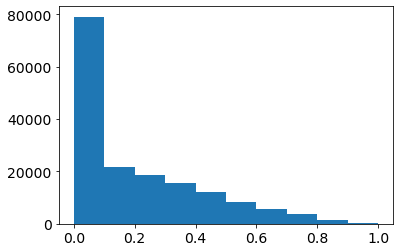

In [256]:
abins = None
plt.hist(AGN_model,bins=abins);

In [257]:
model_cube_sf_agn = model_cube_sf_agn.to_numpy().T
model_cube_qt_agn = model_cube_qt_agn.to_numpy().T
model_cube_agn = model_cube_agn.to_numpy().T

In [277]:
model_cube_three_agn = model_cube_three_agn.to_numpy().T

In [258]:
model_cube_three_pop = model_cube_agn.copy() 
model_cube_three_pop[-1,idx_ahat] = 2

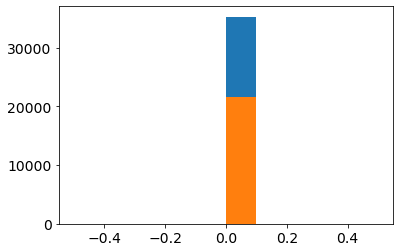

In [259]:
plt.hist(model_cube_sf_agn[2]);
plt.hist(model_cube_qt_agn[2]);

In [260]:
model_cube_sf = model_cube_sf_agn.copy() # rename model_cube to model_cube_agn
model_cube_qt = model_cube_qt_agn.copy() # nonsense, need to rename model_cube_qt to model_cube_agn_qt
model_cube = model_cube_agn.copy() # nonsense, need to rename model_cube_qt to model_cube_agn_qt
model_cube_sf[2] = 0
model_cube_qt[2] = 0
model_cube[2] = 0

In [41]:
A_model_sf_agn = model_A_Tdust(cov_Adust_sf.params, model_cube_sf_agn)
T_model_sf_agn = model_A_Tdust(cov_Tdust_sf.params, model_cube_sf_agn)
#sed_model_params_sf_agn = {'A':cov_Adust_sf.params, 'Tdust':cov_Tdust_sf.params}

In [42]:
A_model_qt_agn = model_A_Tdust(cov_Adust_qt.params, model_cube_qt_agn)
T_model_qt_agn = model_A_Tdust(cov_Tdust_qt.params, model_cube_qt_agn)
#sed_model_params_qt_agn = {'A':cov_Adust_qt.params, 'Tdust':cov_Tdust_qt.params}

## Fit parameters directly to maps?

In [44]:
idx_sim_sf = (A_model_sf_agn > -35.5) & (A_model_sf_agn < -32) & (T_model_sf_agn < 65) & (Z_model_sf > 0.1) #& (AGN_model_sf > 0) 
idx_sim_qt = (A_model_qt_agn > -35.5) & (A_model_qt_agn < -32) & (T_model_qt_agn < 65) & (Z_model_qt > 0.1) #& (AGN_model_qt > 0) 

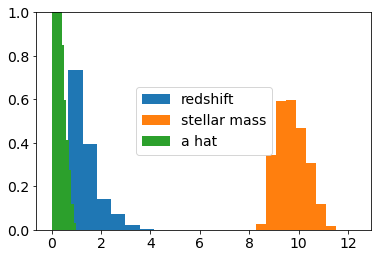

In [45]:
plt.hist(model_cube_sf_agn[:,idx_sim_sf][0], density=True, label='redshift')
plt.hist(model_cube_sf_agn[:,idx_sim_sf][1], density=True, label='stellar mass')
plt.hist(model_cube_sf_agn[:,idx_sim_sf][2], density=True, label='a hat')
plt.ylim([0,1])
plt.legend(loc='center');

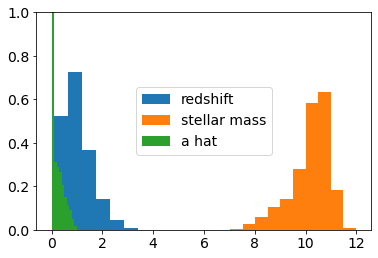

In [46]:
plt.hist(model_cube_qt_agn[:,idx_sim_qt][0], density=True, label='redshift')
plt.hist(model_cube_qt_agn[:,idx_sim_qt][1], density=True, label='stellar mass')
plt.hist(model_cube_qt_agn[:,idx_sim_qt][2], density=True, label='a hat')
plt.ylim([0,1])
plt.legend(loc='center');

In [47]:
map_dict_sf = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf[idx_sim_sf], dec_model_sf[idx_sim_sf])
    #x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords'] = [x,y]
    map_dict_sf[map_key]=map_object

In [48]:
map_dict_qt = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt[idx_sim_qt], dec_model_qt[idx_sim_qt])
    #x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords'] = [x,y]
    map_dict_qt[map_key]=map_object

In [49]:
map_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    map_object['map_coords']={}
    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords']['sf'] = [x_sf,y_sf]
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords']['qt'] = [x_qt,y_qt]
    map_dict[map_key]=map_object

In [261]:
map_dict_three_pop = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key].copy()
    map_object['map_coords']={}
    x_sf, y_sf = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    map_object['map_coords']['sf'] = [x_sf,y_sf]
    x_qt, y_qt = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    map_object['map_coords']['qt'] = [x_qt,y_qt]
    x_agn, y_agn = get_x_y_from_ra_dec(map_object, ra_model_three, dec_model_three)
    map_object['map_coords']['agn'] = [x_agn,y_agn]
    map_dict_three_pop[map_key]=map_object

In [50]:
def direct_convolved_fit_A_Tdust_one_pop(params, X, y):

    v = params.valuesdict()#.copy()
    A_model = v.pop('A_offset')
    T_model = v.pop('T_offset')
    Z_model = X[0]
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            A_model+= X[i] * v[ival]
        else:
            T_model+= X[i] * v[ival]
            i+=1
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords = y[map_name]['map_coords']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)
        
        S_model = get_map_flux_mJy(np.array([map_nu]),A_model,T_model/(1+Z_model))
        map_model[map_coords[0],map_coords[1]]+=S_model
        map_pixels[map_coords[0],map_coords[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

In [51]:
def direct_convolved_fit_A_Tdust_two_pop(params, X, y):

    v = params.valuesdict()#.copy()
    A_model_sf = v.pop('A_offset_sf')
    T_model_sf = v.pop('T_offset_sf')
    A_model_qt = v.pop('A_offset_qt')
    T_model_qt = v.pop('T_offset_qt')
    idx_sf = X[-1] == 1
    idx_qt = X[-1] == 0
    Z_model_sf = X[0][idx_sf]
    Z_model_qt = X[0][idx_qt]
    
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            if 'sf' in ival:
                A_model_sf+= X[i][idx_sf] * v[ival]
            else:
                A_model_qt+= X[i][idx_qt] * v[ival]
        else:
            if 'sf' in ival:
                T_model_sf+= X[i][idx_sf] * v[ival]
            else:
                T_model_qt+= X[i][idx_qt] * v[ival]
                i+=1
                
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords_sf = y[map_name]['map_coords']['sf']
        map_coords_qt = y[map_name]['map_coords']['qt']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)

        S_model_sf = get_map_flux_mJy(np.array([map_nu]),A_model_sf,T_model_sf/(1+Z_model_sf))
        S_model_qt = get_map_flux_mJy(np.array([map_nu]),A_model_qt,T_model_qt/(1+Z_model_qt))
        
        map_model[map_coords_sf[0],map_coords_sf[1]]+=S_model_sf
        map_model[map_coords_qt[0],map_coords_qt[1]]+=S_model_qt
        map_pixels[map_coords_sf[0],map_coords_sf[1]]+=1
        map_pixels[map_coords_qt[0],map_coords_qt[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
    return out_model

In [265]:
def direct_convolved_fit_A_Tdust_three_pop(params, X, y):

    v = params.valuesdict()#.copy()
    A_model_sf = v.pop('A_offset_sf')
    T_model_sf = v.pop('T_offset_sf')
    A_model_qt = v.pop('A_offset_qt')
    T_model_qt = v.pop('T_offset_qt')
    A_model_agn = v.pop('A_offset_agn')
    T_model_agn = v.pop('T_offset_agn')
    
    idx_sf = X[-1] == 1
    idx_qt = X[-1] == 0
    idx_agn= X[-1] == 2
    Z_model_sf = X[0][idx_sf]
    Z_model_qt = X[0][idx_qt]
    Z_model_agn = X[0][idx_agn]
    
    i=0
    for ival in v:
        #print(ival)
        if 'A_' in ival:
            if 'sf' in ival:
                A_model_sf+= X[i][idx_sf] * v[ival]
            elif 'qt' in ival:
                A_model_qt+= X[i][idx_qt] * v[ival]
            else:
                A_model_agn+= X[i][idx_agn] * v[ival]
        else:
            if 'sf' in ival:
                T_model_sf+= X[i][idx_sf] * v[ival]
            elif 'qt' in ival:
                T_model_qt+= X[i][idx_qt] * v[ival]
            else:
                T_model_agn+= X[i][idx_agn] * v[ival]
                i+=1
                
    #pdb.set_trace()
    out_model = []
    for map_name in y:
        map_lambda = y[map_name]['wavelength']
        map_nu = c * 1.e6/map_lambda
        map_coords_sf = y[map_name]['map_coords']['sf']
        map_coords_qt = y[map_name]['map_coords']['qt']
        map_coords_agn = y[map_name]['map_coords']['agn']
        hd = y[map_name]['header']
        map_sky = y[map_name]['map'] - np.mean(y[map_name]['map'])

        map_model = np.zeros_like(map_sky)
        map_pixels= np.zeros_like(map_sky)

        S_model_sf = get_map_flux_mJy(np.array([map_nu]),A_model_sf,T_model_sf/(1+Z_model_sf))
        S_model_qt = get_map_flux_mJy(np.array([map_nu]),A_model_qt,T_model_qt/(1+Z_model_qt))
        S_model_agn = get_map_flux_mJy(np.array([map_nu]),A_model_agn,T_model_agn/(1+Z_model_agn))

        map_model[map_coords_sf[0],map_coords_sf[1]]+=S_model_sf
        map_model[map_coords_qt[0],map_coords_qt[1]]+=S_model_qt
        map_model[map_coords_agn[0],map_coords_agn[1]]+=S_model_agn
        map_pixels[map_coords_sf[0],map_coords_sf[1]]+=1
        map_pixels[map_coords_qt[0],map_coords_qt[1]]+=1
        map_pixels[map_coords_agn[0],map_coords_agn[1]]+=1
        
        fwhm = y[map_name]['fwhm']
        pix = y[map_name]['pixel_size']
        kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
        tmap = smooth_psf(map_model, kern)
        tmap -= np.mean(tmap)

        idx_fit = map_pixels != 0
        diff = map_sky - tmap
        out_model.extend(np.ravel(diff[idx_fit]))
            
        #pdb.set_trace()    
    return out_model

# Fit just SF simultaneously

In [52]:
#These are the initial guesses
cov_Adust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,-40.8404806,0.66472732,(1.63%),-0.0006449930728213138,-inf,inf,True
slope_redshift,0.16486051,0.04352322,(26.40%),1.4,-inf,inf,True
slope_stellar_mass,0.60138253,0.06401503,(10.64%),-0.0006909992357812739,-inf,inf,True
slope_agn_fraction,0.24998435,0.15286833,(61.15%),0.0022150171609157843,-inf,inf,True


In [53]:
#These are the initial guesses
cov_Tdust_sf.params

name,value,standard error,relative error,initial value,min,max,vary
offset,19.1782349,12.1707710,(63.46%),-0.00047127608245707775,-inf,inf,True
slope_redshift,4.85107431,0.79688562,(16.43%),1.4,-inf,inf,True
slope_stellar_mass,0.04123376,1.17207810,(2842.52%),-0.0006909992357812739,-inf,inf,True
slope_agn_fraction,7.10201551,2.79893405,(39.41%),0.0022150171609157843,-inf,inf,True


In [54]:
# Define Fit Parameters
fit_params_sf = Parameters()
fit_params_sf.add('A_offset', value=cov_Adust_sf.params['offset'].value)
fit_params_sf.add('T_offset', value=cov_Tdust_sf.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sf.add('A_slope_'+key, value=cov_Adust_sf.params['slope_'+key].value)
        fit_params_sf.add('T_slope_'+key, value=cov_Tdust_sf.params['slope_'+key].value)
    
cov_direct_fit_sf = minimize(direct_convolved_fit_A_Tdust_one_pop, fit_params_sf,
                     args=(model_cube_sf_agn[:,idx_sim_sf],),
                     kws={'y':map_dict_sf},
                     nan_policy='propagate')

In [55]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-41.6756837,0.01564959,(0.04%),-40.84048063451176,-inf,inf,True
T_offset,20.0103255,0.04725453,(0.24%),19.17823487515869,-inf,inf,True
A_slope_redshift,0.33168086,0.00328221,(0.99%),0.16486051081946568,-inf,inf,True
T_slope_redshift,1.46485739,0.05054380,(3.45%),4.851074305310842,-inf,inf,True
A_slope_stellar_mass,0.67451153,0.00147307,(0.22%),0.6013825268878782,-inf,inf,True
T_slope_stellar_mass,-0.00421728,2.5729e-04,(6.10%),0.041233761992037404,-inf,inf,True
A_slope_agn_fraction,-0.36782156,0.01031471,(2.80%),0.2499843457617593,-inf,inf,True
T_slope_agn_fraction,17.6430186,0.15624530,(0.89%),7.102015508899259,-inf,inf,True


In [39]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-43.2147342,0.04495931,(0.10%),-40.840480171743245,-inf,inf,True
T_offset,42.3455040,0.60497205,(1.43%),19.178139680302618,-inf,inf,True
A_slope_redshift,0.35716881,0.00353787,(0.99%),0.16486057757935488,-inf,inf,True
T_slope_redshift,0.98051183,0.05255477,(5.36%),4.851072402024176,-inf,inf,True
A_slope_stellar_mass,0.82586113,0.00428858,(0.52%),0.6013824797885865,-inf,inf,True
T_slope_stellar_mass,-2.14919379,0.05722234,(2.66%),0.04124301521757193,-inf,inf,True
A_slope_agn_fraction,-0.59735099,0.01157900,(1.94%),0.24998414144114753,-inf,inf,True
T_slope_agn_fraction,20.2963172,0.17437212,(0.86%),7.102018676954382,-inf,inf,True


In [56]:
# Define Fit Parameters
fit_params_qt = Parameters()
fit_params_qt.add('A_offset', value=cov_Adust_qt.params['offset'].value)
fit_params_qt.add('T_offset', value=cov_Tdust_qt.params['offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_qt.add('A_slope_'+key, value=cov_Adust_qt.params['slope_'+key].value)
        fit_params_qt.add('T_slope_'+key, value=cov_Tdust_qt.params['slope_'+key].value)
    
cov_direct_fit_qt = minimize(direct_convolved_fit_A_Tdust_one_pop, fit_params_qt,
                     args=(model_cube_qt_agn[:,idx_sim_qt],),
                     kws={'y':map_dict_qt},
                     nan_policy='propagate')

In [57]:
cov_direct_fit_qt.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-44.8748899,0.31248926,(0.70%),-33.27064451941986,-inf,inf,True
T_offset,75.3665447,3.26838792,(4.34%),-33.0544640157521,-inf,inf,True
A_slope_redshift,0.05637707,0.01600197,(28.38%),0.2626630532248703,-inf,inf,True
T_slope_redshift,8.31413269,0.22345001,(2.69%),6.4606961920023975,-inf,inf,True
A_slope_stellar_mass,0.96796633,0.02984908,(3.08%),-0.1292522297030581,-inf,inf,True
T_slope_stellar_mass,-5.96308759,0.30486838,(5.11%),4.698399142986683,-inf,inf,True
A_slope_agn_fraction,-0.14847934,0.06633243,(44.67%),-0.4036363192368518,-inf,inf,True
T_slope_agn_fraction,15.7318925,1.03079605,(6.55%),12.312799162845714,-inf,inf,True


In [58]:
vT_just_sf = cov_direct_fit_sf.params.copy()
vA_just_sf = cov_direct_fit_sf.params.copy()
vT_just_qt = cov_direct_fit_qt.params.copy()
vA_just_qt = cov_direct_fit_qt.params.copy()

Alist = [i for i, j in vA_just_sf.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_just_sf.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_just_sf.pop(i) for i in Tlist]
Tpop=[vT_just_sf.pop(i) for i in Alist]

Alist = [i for i, j in vA_just_qt.items() if (('A_' in i) or ('_sf' in i))]
Tlist = [i for i, j in vT_just_qt.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_just_qt.pop(i) for i in Tlist]
Tpop=[vT_just_qt.pop(i) for i in Alist]

In [59]:
vT_just_sf

name,value,standard error,relative error,initial value,min,max,vary
T_offset,20.0103255,0.04725453,(0.24%),19.17823487515869,-inf,inf,True
T_slope_redshift,1.46485739,0.05054380,(3.45%),4.851074305310842,-inf,inf,True
T_slope_stellar_mass,-0.00421728,2.5729e-04,(6.10%),0.041233761992037404,-inf,inf,True
T_slope_agn_fraction,17.6430186,0.15624530,(0.89%),7.102015508899259,-inf,inf,True


In [60]:
vA_just_sf

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-41.6756837,0.01564959,(0.04%),-40.84048063451176,-inf,inf,True
A_slope_redshift,0.33168086,0.00328221,(0.99%),0.16486051081946568,-inf,inf,True
A_slope_stellar_mass,0.67451153,0.00147307,(0.22%),0.6013825268878782,-inf,inf,True
A_slope_agn_fraction,-0.36782156,0.01031471,(2.80%),0.2499843457617593,-inf,inf,True


In [61]:
vT_just_qt

name,value,standard error,relative error,initial value,min,max,vary
T_offset,75.3665447,3.26838792,(4.34%),-33.0544640157521,-inf,inf,True
T_slope_redshift,8.31413269,0.22345001,(2.69%),6.4606961920023975,-inf,inf,True
T_slope_stellar_mass,-5.96308759,0.30486838,(5.11%),4.698399142986683,-inf,inf,True
T_slope_agn_fraction,15.7318925,1.03079605,(6.55%),12.312799162845714,-inf,inf,True


In [62]:
vA_just_qt

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-44.8748899,0.31248926,(0.70%),-33.27064451941986,-inf,inf,True
A_slope_redshift,0.05637707,0.01600197,(28.38%),0.2626630532248703,-inf,inf,True
A_slope_stellar_mass,0.96796633,0.02984908,(3.08%),-0.1292522297030581,-inf,inf,True
A_slope_agn_fraction,-0.14847934,0.06633243,(44.67%),-0.4036363192368518,-inf,inf,True


In [63]:
A_combined_model_just_sf_agn = model_A_or_Tdust(vA_just_sf, model_cube_sf_agn)
T_combined_model_just_sf_agn = model_A_or_Tdust(vT_just_sf, model_cube_sf_agn)

In [64]:
A_combined_model_just_sf = model_A_or_Tdust(vA_just_sf, model_cube_sf)
T_combined_model_just_sf = model_A_or_Tdust(vT_just_sf, model_cube_sf)

In [65]:
A_combined_model_just_qt = model_A_or_Tdust(vA_just_qt, model_cube_qt)
T_combined_model_just_qt = model_A_or_Tdust(vT_just_qt, model_cube_qt)

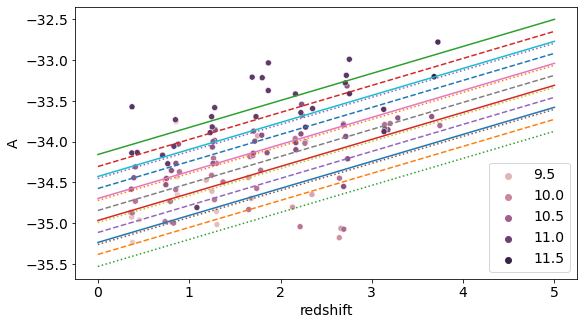

In [66]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

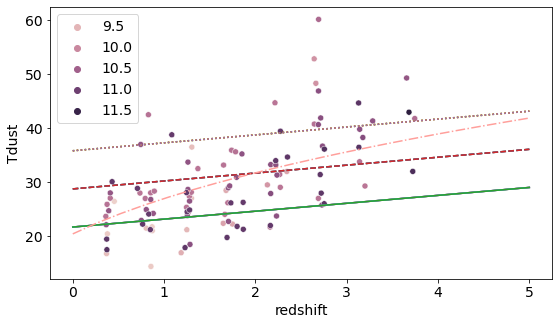

In [201]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf]-1, hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_just_sf, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.r');

In [85]:
combined_theta_model_just_sf_agn = A_combined_model_just_sf_agn, np.array(T_combined_model_just_sf_agn / (1+Z_model_sf))

In [86]:
combined_theta_model_just_sf= A_combined_model_just_sf, np.array(T_combined_model_just_sf / (1+Z_model_sf))

# Now fit SF and QT simultaneously

In [71]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=vA_just_sf['A_offset'].value)
fit_params_sfg.add('T_offset_sf', value=vT_just_sf['T_offset'].value)
fit_params_sfg.add('A_offset_qt', value=vA_just_qt['A_offset'].value)
fit_params_sfg.add('T_offset_qt', value=vT_just_qt['T_offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sfg.add('A_slope_'+key+'_sf', value=vA_just_sf['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=vT_just_sf['T_slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=vA_just_qt['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=vT_just_qt['T_slope_'+key].value)
    
cov_direct_fit_agn = minimize(direct_convolved_fit_A_Tdust_two_pop, fit_params_sfg,
                     args=(model_cube_agn,),
                     kws={'y':map_dict},
                     nan_policy='propagate')

In [266]:
# Define Fit Parameters
fit_params_sfg = Parameters()
fit_params_sfg.add('A_offset_sf', value=vA_just_sf['A_offset'].value)
fit_params_sfg.add('T_offset_sf', value=vT_just_sf['T_offset'].value)
fit_params_sfg.add('A_offset_qt', value=vA_just_qt['A_offset'].value)
fit_params_sfg.add('T_offset_qt', value=vT_just_qt['T_offset'].value)
fit_params_sfg.add('A_offset_agn', value=vA_just_sf['A_offset'].value)
fit_params_sfg.add('T_offset_agn', value=vT_just_sf['T_offset'].value)

for key, val in simstack_object.config_dict['catalog']['classification'].items():

    if 'split_params' not in key:
        fit_params_sfg.add('A_slope_'+key+'_sf', value=vA_just_sf['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_sf', value=vT_just_sf['T_slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_qt', value=vA_just_qt['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_qt', value=vT_just_qt['T_slope_'+key].value)
        fit_params_sfg.add('A_slope_'+key+'_agn', value=vA_just_sf['A_slope_'+key].value)
        fit_params_sfg.add('T_slope_'+key+'_agn', value=vT_just_sf['T_slope_'+key].value)
        
cov_direct_fit_three = minimize(direct_convolved_fit_A_Tdust_three_pop, fit_params_sfg,
                     args=(model_cube_three_pop,),
                     kws={'y':map_dict_three_pop},
                     nan_policy='propagate')

In [286]:
vT_sf_three = cov_direct_fit_three.params.copy()
vA_sf_three = cov_direct_fit_three.params.copy()
vT_qt_three = cov_direct_fit_three.params.copy()
vA_qt_three = cov_direct_fit_three.params.copy()
vT_agn_three = cov_direct_fit_three.params.copy()
vA_agn_three = cov_direct_fit_three.params.copy()

Alist = [i for i, j in vA_sf_three.items() if (('A_' in i) or ('_qt' in i) or ('t_agn' in i) or ('s_agn' in i) or ('n_agn' in i))]
Tlist = [i for i, j in vT_sf_three.items() if (('T_' in i) or ('_qt' in i) or ('t_agn' in i) or ('s_agn' in i) or ('n_agn' in i))]
Apop=[vA_sf_three.pop(i) for i in Tlist]
Tpop=[vT_sf_three.pop(i) for i in Alist]

Alist = [i for i, j in vA_qt_three.items() if (('A_' in i) or ('_sf' in i) or ('t_agn' in i) or ('s_agn' in i) or ('n_agn' in i))]
Tlist = [i for i, j in vT_qt_three.items() if (('T_' in i) or ('_sf' in i) or ('t_agn' in i) or ('s_agn' in i) or ('n_agn' in i))]
Apop=[vA_qt_three.pop(i) for i in Tlist]
Tpop=[vT_qt_three.pop(i) for i in Alist]

Alist = [i for i, j in vA_agn_three.items() if (('A_' in i) or ('_sf' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_agn_three.items() if (('T_' in i) or ('_sf' in i) or ('_qt' in i))]
Apop=[vA_agn_three.pop(i) for i in Tlist]
Tpop=[vT_agn_three.pop(i) for i in Alist]

In [287]:
print(np.shape(model_cube_sf_agn))
print(np.shape(model_cube_qt_agn))
print(np.shape(model_cube_three_agn))


(3, 35243)
(3, 21618)
(3, 109772)


In [289]:
vA_qt_three

name,value,initial value,min,max,vary
A_offset_qt,-50.1751921,-44.87488987131692,-inf,inf,True
A_slope_redshift_qt,0.16571854,0.056377072768809926,-inf,inf,True
A_slope_stellar_mass_qt,1.35866264,0.9679663305072463,-inf,inf,True
A_slope_agn_fraction_qt,-0.14847934,-0.14847934225390974,-inf,inf,True


In [291]:
vT_qt_three

name,value,initial value,min,max,vary
T_offset_qt,128.909360,75.36654468901773,-inf,inf,True
T_slope_redshift_qt,9.15477298,8.314132690916804,-inf,inf,True
T_slope_stellar_mass_qt,-11.0449355,-5.96308759493832,-inf,inf,True
T_slope_agn_fraction_qt,15.7318925,15.731892532639176,-inf,inf,True


In [292]:
vA_agn_three

name,value,initial value,min,max,vary
A_offset_agn,-40.9348217,-41.67568368653115,-inf,inf,True
A_slope_redshift_agn,0.36564602,0.33168086026378407,-inf,inf,True
A_slope_stellar_mass_agn,0.60559871,0.6745115315913107,-inf,inf,True
A_slope_agn_fraction_agn,-0.59692926,-0.3678215594178765,-inf,inf,True


In [293]:
vT_agn_three

name,value,initial value,min,max,vary
T_offset_agn,18.4037340,20.010325463509947,-inf,inf,True
T_slope_redshift_agn,0.79043170,1.464857388340239,-inf,inf,True
T_slope_stellar_mass_agn,-0.00736262,-0.00421727872552361,-inf,inf,True
T_slope_agn_fraction_agn,24.1386825,17.643018566715124,-inf,inf,True


In [295]:
A_combined_model_sf_three = model_A_or_Tdust_three(vA_sf_three, model_cube_sf_agn)
T_combined_model_sf_three = model_A_or_Tdust_three(vT_sf_three, model_cube_sf_agn)

A_combined_model_qt_three = model_A_or_Tdust_three(vA_qt_three, model_cube_qt_agn)
T_combined_model_qt_three = model_A_or_Tdust_three(vT_qt_three, model_cube_qt_agn)

A_combined_model_agn_three = model_A_or_Tdust_three(vA_agn_three, model_cube_three_agn)
T_combined_model_agn_three = model_A_or_Tdust_three(vT_agn_three, model_cube_three_agn)

In [268]:
cov_direct_fit_three.params

name,value,initial value,min,max,vary
A_offset_sf,-41.9637010,-41.67568368653115,-inf,inf,True
T_offset_sf,22.6568988,20.010325463509947,-inf,inf,True
A_offset_qt,-50.1751921,-44.87488987131692,-inf,inf,True
T_offset_qt,128.909360,75.36654468901773,-inf,inf,True
A_offset_agn,-40.9348217,-41.67568368653115,-inf,inf,True
T_offset_agn,18.4037340,20.010325463509947,-inf,inf,True
A_slope_redshift_sf,0.17200100,0.33168086026378407,-inf,inf,True
T_slope_redshift_sf,3.00129637,1.464857388340239,-inf,inf,True
A_slope_redshift_qt,0.16571854,0.056377072768809926,-inf,inf,True
T_slope_redshift_qt,9.15477298,8.314132690916804,-inf,inf,True


In [72]:
cov_direct_fit_sf.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset,-41.6756837,0.01564959,(0.04%),-40.84048063451176,-inf,inf,True
T_offset,20.0103255,0.04725453,(0.24%),19.17823487515869,-inf,inf,True
A_slope_redshift,0.33168086,0.00328221,(0.99%),0.16486051081946568,-inf,inf,True
T_slope_redshift,1.46485739,0.05054380,(3.45%),4.851074305310842,-inf,inf,True
A_slope_stellar_mass,0.67451153,0.00147307,(0.22%),0.6013825268878782,-inf,inf,True
T_slope_stellar_mass,-0.00421728,2.5729e-04,(6.10%),0.041233761992037404,-inf,inf,True
A_slope_agn_fraction,-0.36782156,0.01031471,(2.80%),0.2499843457617593,-inf,inf,True
T_slope_agn_fraction,17.6430186,0.15624530,(0.89%),7.102015508899259,-inf,inf,True


In [87]:
cov_direct_fit_agn.params

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-41.7987753,0.01529107,(0.04%),-41.67568368653115,-inf,inf,True
T_offset_sf,21.5319820,0.09038183,(0.42%),20.010325463509947,-inf,inf,True
A_offset_qt,-38.0871682,0.46879324,(1.23%),-44.87488987131692,-inf,inf,True
T_offset_qt,-22.7987783,6.09732040,(26.74%),75.36654468901773,-inf,inf,True
A_slope_redshift_sf,0.32436208,0.00309800,(0.96%),0.33168086026378407,-inf,inf,True
T_slope_redshift_sf,1.50703291,0.04797471,(3.18%),1.464857388340239,-inf,inf,True
A_slope_redshift_qt,0.30887068,0.02630897,(8.52%),0.056377072768809926,-inf,inf,True
T_slope_redshift_qt,2.94265839,0.41141578,(13.98%),8.314132690916804,-inf,inf,True
A_slope_stellar_mass_sf,0.68611707,0.00141735,(0.21%),0.6745115315913107,-inf,inf,True
T_slope_stellar_mass_sf,-0.14477865,0.00687201,(4.75%),-0.00421727872552361,-inf,inf,True


In [74]:
vT_sf_agn = cov_direct_fit_agn.params.copy()
vA_sf_agn = cov_direct_fit_agn.params.copy()
vT_qt_agn = cov_direct_fit_agn.params.copy()
vA_qt_agn = cov_direct_fit_agn.params.copy()

Alist = [i for i, j in vA_sf_agn.items() if (('A_' in i) or ('_qt' in i))]
Tlist = [i for i, j in vT_sf_agn.items() if (('T_' in i) or ('_qt' in i))]
Apop=[vA_sf_agn.pop(i) for i in Tlist]
Tpop=[vT_sf_agn.pop(i) for i in Alist]

Alist_qt = [i for i, j in vA_qt_agn.items() if (('A_' in i) or ('_sf' in i))]
Tlist_qt = [i for i, j in vT_qt_agn.items() if (('T_' in i) or ('_sf' in i))]
Apop=[vA_qt_agn.pop(i) for i in Tlist_qt]
Tpop=[vT_qt_agn.pop(i) for i in Alist_qt]

In [76]:
vA_sf_agn

name,value,standard error,relative error,initial value,min,max,vary
A_offset_sf,-41.7987753,0.01529107,(0.04%),-41.67568368653115,-inf,inf,True
A_slope_redshift_sf,0.32436208,0.00309800,(0.96%),0.33168086026378407,-inf,inf,True
A_slope_stellar_mass_sf,0.68611707,0.00141735,(0.21%),0.6745115315913107,-inf,inf,True
A_slope_agn_fraction_sf,-0.34188273,0.00966888,(2.83%),-0.3678215594178765,-inf,inf,True


In [77]:
A_combined_model_sf_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn)
T_combined_model_sf_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn)

A_combined_model_qt_agn = model_A_or_Tdust(vA_qt_agn, model_cube_qt_agn)
T_combined_model_qt_agn = model_A_or_Tdust(vT_qt_agn, model_cube_qt_agn)

In [78]:
A_combined_model_sf = model_A_or_Tdust(vA_sf_agn, model_cube_sf)
T_combined_model_sf = model_A_or_Tdust(vT_sf_agn, model_cube_sf)

A_combined_model_qt = model_A_or_Tdust(vA_qt_agn, model_cube_qt)
T_combined_model_qt = model_A_or_Tdust(vT_qt_agn, model_cube_qt)

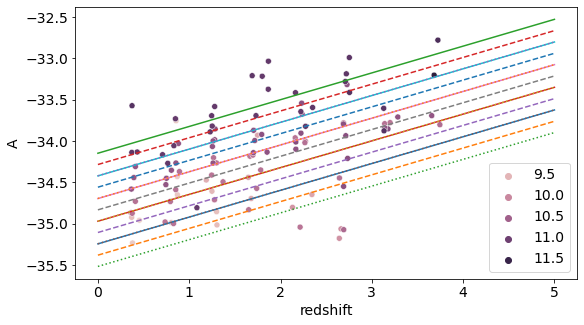

In [79]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],As_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_sf_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_sf_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

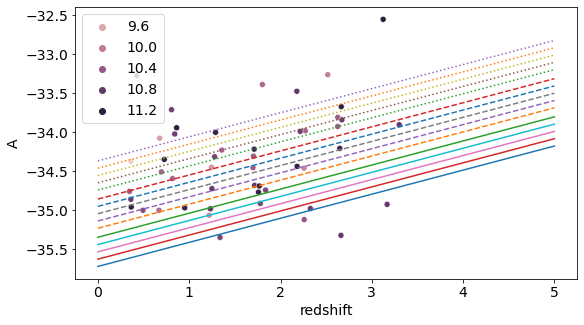

In [80]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],As_qt[idx_keep_qt], hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='A')
fig.set(xlabel='redshift');
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            A_mod_plot = model_A_or_Tdust(vA_qt_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, A_mod_plot, as_ls[j])
    except:
        A_mod_plot = model_A_or_Tdust(vA_qt_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, A_mod_plot)

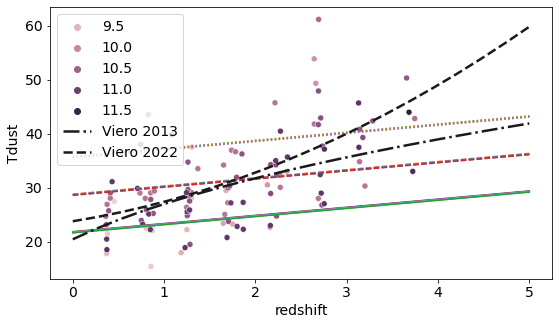

In [272]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_sf[idx_keep_sf],Ts_sf[idx_keep_sf], hue=Ms_sf[idx_keep_sf])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_sf_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_sf_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

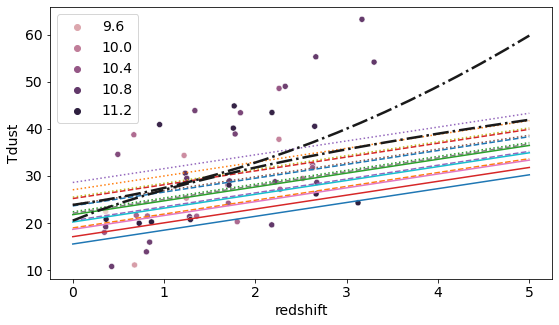

In [203]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.set_color_codes(palette='pastel')
fig=sns.scatterplot(Zs_qt[idx_keep_qt],Ts_qt[idx_keep_qt]-1, hue=Ms_qt[idx_keep_qt])
#fig.set(ylim=(-38,-32))
fig.set(ylabel='Tdust')
fig.set(xlabel='redshift')
zs_model=np.linspace(0,5,20)
ms_list=[9.6,10,10.4,10.8,11.2]
as_list=[.1,.5,.9]
as_ls=['-','--',':']
for i, im in enumerate(ms_list):
    ms_model=np.zeros_like(zs_model)+im
    try:
        for j, ja in enumerate(as_list):
            as_model=np.zeros_like(zs_model)+ja
            T_mod_plot = model_A_or_Tdust(vT_qt_agn, np.array([zs_model.tolist(),ms_model.tolist(),as_model.tolist()]))
            plt.plot(zs_model, T_mod_plot, as_ls[j])
    except:
        T_mod_plot = model_A_or_Tdust(vT_qt_agn, np.array([zs_model.tolist(),ms_model.tolist()]))
        plt.plot(zs_model, T_mod_plot)
        
plt.plot(zs_model, 27*((1+zs_model)/(1+1))**(0.4), '-.k', lw=2.5, label='Viero 2013');
Tv22 = 23.8 + 2.7 * zs_model + 0.9 * zs_model**2
plt.plot(zs_model, Tv22, '--k', lw=2.5, label='Viero 2022');
plt.legend();

# Decompose LIR into AGN and non-AGN

In [90]:
L_sun = 3.839e26  # W
c = 299792458.0  # m/s
def fast_LIR(self, theta, zed, dzin=None):
    '''This calls graybody_fn instead of fast_sed'''
    wavelength_range = self.loggen(8, 1000, 1000)
    Lrf_array = np.zeros_like(zed)
    for iz, zin in enumerate(zed):
        theta_in = theta[0][iz], theta[1][iz]
        model_sed = self.graybody_fn(theta_in, wavelength_range)

        nu_in = c * 1.e6 / wavelength_range
        dnu = nu_in[:-1] - nu_in[1:]
        dnu = np.append(dnu[0], dnu)
        Lir = np.sum(model_sed * dnu, axis=1)
        conversion = 4.0 * np.pi * (
                    1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                zin) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)

        Lrf = (Lir * conversion.value)[0]  # Jy x Hz

        if dzin is not None:
            dLrf = np.zeros([2])
            for idz, dz in enumerate(dzin):
                conversion = 4.0 * np.pi * (
                        1.0E-13 * self.config_dict['cosmology_dict']['cosmology'].luminosity_distance(
                    dz) * 3.08568025E22) ** 2.0 / L_sun  # 4 * pi * D_L^2    units are L_sun/(Jy x Hz)
                dLrf[idz] = (Lir * conversion.value)[0]

            #return Lrf, dLrf
            Lrf_array[iz] = Lrf, dLrf
            
        Lrf_array[iz] = Lrf

    return Lrf_array

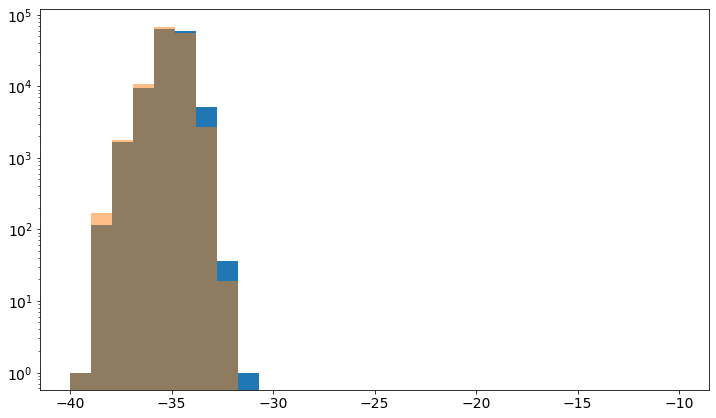

In [91]:
fig, axs = plt.subplots(1, 1, figsize=(12,7))
hbins=np.linspace(-40,-10,30)
plt.hist(A_combined_model_sf, bins=hbins);
plt.hist(A_combined_model_sf_agn, bins=hbins, alpha=0.5);
plt.yscale('log')

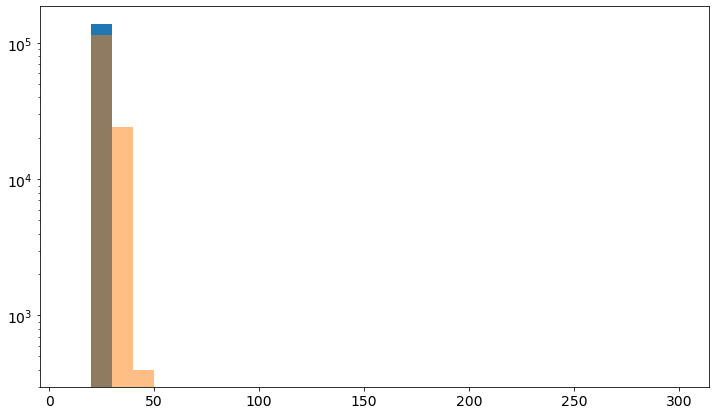

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(12,7))
hbins=np.linspace(10,300,30)
plt.hist(T_combined_model_sf, bins=hbins);
plt.hist(T_combined_model_sf_agn, bins=hbins, alpha=0.5);
plt.yscale('log')

In [93]:
combined_theta_model_sf_agn = A_combined_model_sf_agn, np.array(T_combined_model_sf_agn / (1+Z_model_sf))
combined_theta_model_qt_agn = A_combined_model_qt_agn, np.array(T_combined_model_qt_agn / (1+Z_model_qt))

In [94]:
combined_theta_model_sf = A_combined_model_sf, np.array(T_combined_model_sf / (1+Z_model_sf))
combined_theta_model_qt = A_combined_model_qt, np.array(T_combined_model_qt / (1+Z_model_qt))

In [95]:
LIR_model_just_sf_agn = fast_LIR(simstack_object, combined_theta_model_just_sf_agn, Z_model_sf)

In [96]:
LIR_model_just_sf = fast_LIR(simstack_object, combined_theta_model_just_sf, Z_model_sf)

In [97]:
LIR_model_sf = fast_LIR(simstack_object, combined_theta_model_sf, Z_model_sf)

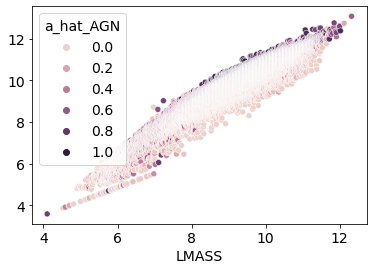

In [221]:
sns.scatterplot(M_model_sf, np.log10(LIR_model_sf), hue=AGN_model_sf);

In [98]:
LIR_model_qt = fast_LIR(simstack_object, combined_theta_model_qt, Z_model_qt)

In [99]:
LIR_model_sf_agn = fast_LIR(simstack_object, combined_theta_model_sf_agn, Z_model_sf)

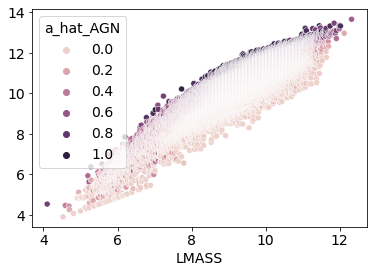

In [220]:
sns.scatterplot(M_model_sf, np.log10(LIR_model_sf_agn), hue=AGN_model_sf);

In [100]:
LIR_model_qt_agn = fast_LIR(simstack_object, combined_theta_model_qt_agn, Z_model_qt)

In [101]:
idx_sample_sf = np.random.choice(np.arange(len(Z_model_sf)), size=10000, replace=False)

In [102]:
idx_sample_qt = np.random.choice(np.arange(len(Z_model_qt)), size=10000, replace=False)

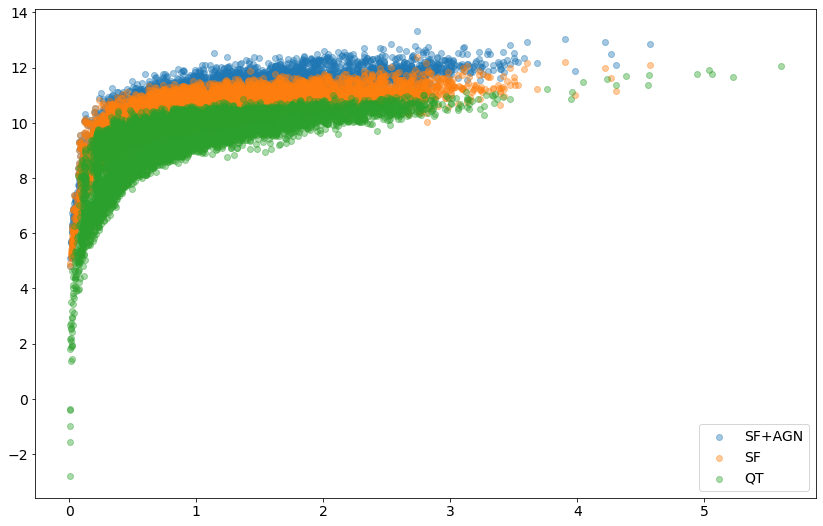

In [103]:
fig, axs = plt.subplots(1, 1, figsize=(14,9))
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf_agn[idx_sample_sf]), alpha=0.4, label='SF+AGN');
plt.scatter(Z_model_sf.iloc[idx_sample_sf], np.log10(LIR_model_sf[idx_sample_sf]), alpha=0.4, label='SF');
plt.scatter(Z_model_qt.iloc[idx_sample_qt], np.log10(LIR_model_qt[idx_sample_qt]), alpha=0.4, label='QT');
plt.legend();

In [108]:
zbins = np.array([0, .25, .5, 1, 1.5, 2, 2.5, 3, 4, 5])
binned_z = (zbins[:-1]+zbins[1:])/2

binned_lir_just_sf_agn = np.zeros(len(zbins)-1)
binned_lir_just_sf = np.zeros(len(zbins)-1)
binned_lir_sf_agn = np.zeros(len(zbins)-1)
binned_lir_sf = np.zeros(len(zbins)-1)
binned_lir_qt_agn = np.zeros(len(zbins)-1)
binned_lir_qt = np.zeros(len(zbins)-1)

binned_uv_sfr_sf = np.zeros(len(zbins)-1)
binned_uv_sfr_qt = np.zeros(len(zbins)-1)
binned_uv_sfr = np.zeros(len(zbins)-1)

binned_vol = np.zeros(len(zbins)-1)
area_deg2 = 1.8 #1.6055

for iz in np.arange(len(zbins)-1):
    idx_z_sf = (Z_model_sf > zbins[iz]) & (Z_model_sf <= zbins[iz+1])
    idx_z_qt = (Z_model_qt > zbins[iz]) & (Z_model_qt <= zbins[iz+1])
    
    binned_lir_just_sf_agn[iz] = np.sum(LIR_model_just_sf_agn[idx_z_sf],axis=0)
    binned_lir_just_sf[iz] = np.sum(LIR_model_just_sf[idx_z_sf],axis=0)
    
    binned_lir_sf_agn[iz] = np.sum(LIR_model_sf_agn[idx_z_sf],axis=0)
    binned_lir_sf[iz] = np.sum(LIR_model_sf[idx_z_sf],axis=0)
    binned_lir_qt_agn[iz] = np.sum(LIR_model_qt_agn[idx_z_qt],axis=0)
    binned_lir_qt[iz] = np.sum(LIR_model_qt[idx_z_qt],axis=0)
    
    binned_uv_sfr_sf[iz] = np.sum(uv_sfr_sf[idx_z_sf])
    binned_uv_sfr_qt[iz] = np.sum(uv_sfr_qt[idx_z_qt])
    
    idx_z_whole = (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] > zbins[iz]) & (simstack_catalog_object.catalog_dict['tables']['full_table']['z_peak'] <= zbins[iz+1])
    binned_uv_sfr[iz] = np.sum(simstack_catalog_object.catalog_dict['tables']['full_table']['SFR_UV'][idx_z_whole])
    
    binned_vol[iz] = simstack_object.comoving_volume_given_area(area_deg2, zbins[iz], zbins[iz+1]).value

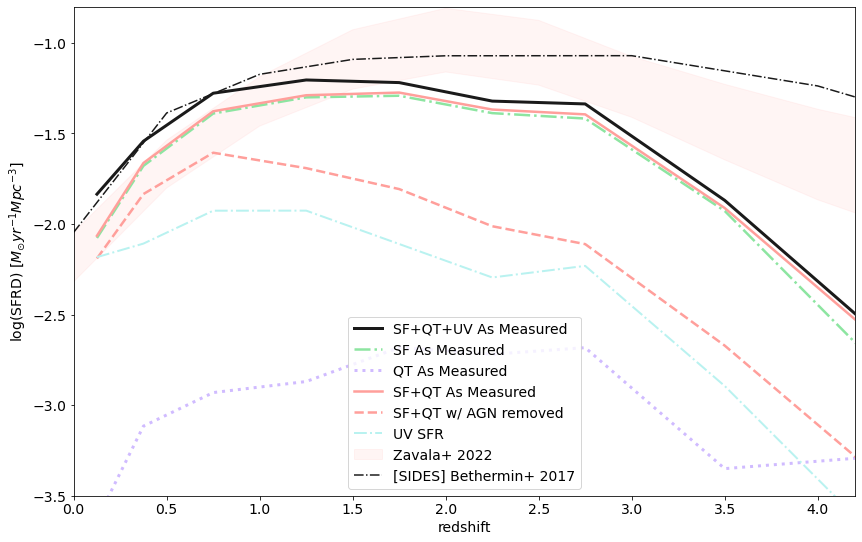

In [191]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=3, label='SF+QT+UV As Measured')
#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn))/binned_vol), '-.g', lw=2.5, label='SF As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), ':m', lw=3, label='QT As Measured')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn))/binned_vol), '-r', lw=2.5, label='SF+QT As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt))/binned_vol), '--r', lw=2.5, label='SF+QT w/ AGN removed')

#plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.c', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='k', lw=1.5, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

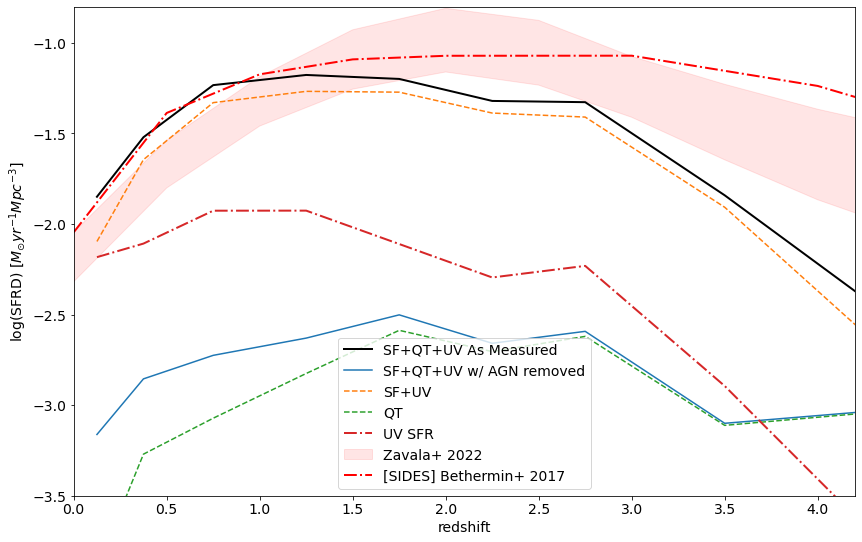

In [58]:
conv_lir_to_sfr = 1.728e-10  / 10 ** 0.23
fig, axs = plt.subplots(1, 1, figsize=(14,9))

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_lir_qt_agn)+binned_uv_sfr_sf)/binned_vol), 'k', lw=2, label='SF+QT+UV As Measured')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf+binned_lir_qt_agn)+binned_uv_sfr_qt)/binned_vol), label='SF+QT+UV w/ AGN removed')

plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_sf_agn+binned_uv_sfr_sf))/binned_vol), '--', label='SF+UV')
plt.plot(binned_z, np.log10((conv_lir_to_sfr*(binned_lir_qt_agn))/binned_vol), '--', label='QT')

plt.plot(binned_z, np.log10(binned_uv_sfr /binned_vol), '-.', lw=2,  label='UV SFR')

xzav = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yzav0 = [0.009, 0.029, 0.065, 0.118, 0.155, 0.133, 0.084, 0.059, 0.043, 0.033, 0.026, 0.02, 0.016, 0.014,
         0.012]
yzav1 = [0.0048, 0.0158, 0.0347, 0.0555, 0.069, 0.0584, 0.0388, 0.0226, 0.0136, 0.009, 0.005, 0.004, 0.0039,
         0.0032, 0.0026]
plt.fill_between(xzav, np.log10(yzav0), np.log10(yzav1), facecolor='r', alpha=0.1, edgecolor='r',
                 label='Zavala+ 2022')

xsides = [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0]
ysides = [0.009, 0.041, 0.067, 0.081, 0.0848, 0.0849, 0.0578, 0.0288, 0.0168, 0.0093, 0.0058]
plt.plot(xsides, np.log10(ysides), '-.', c='r', lw=2, label='[SIDES] Bethermin+ 2017')

xill = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
yill = [0.0117, 0.0253, 0.0431, 0.0562, 0.0674, 0.0666, 0.0651, 0.0531, 0.0500, 0.0455, 0.0295, 0.0193,
        0.0156, 0.0114, 0.008]
#plt.plot(xill, np.log10(yill), '--', c='g', lw=2, label='[IllustrisTNG] Pillepich+ 2018')

plt.xlabel('redshift')
#plt.ylabel('LIRD');
plt.ylabel('log(SFRD) [$M_{\odot} yr^{-1} Mpc^{-3}$]');
plt.xlim([0,4.2])
#plt.ylim([7,9]);
plt.ylim([-3.5,-0.8]);
#plt.ylim(np.l#og10([4e-3,5e-1]));
plt.legend();

# AGN - induced star-formation?

In [124]:
np.shape(model_cube_sf_agn)

(3, 139396)

In [125]:
model_cube_sf_agn

array([[1.000000e-02, 1.000000e-02, 1.000000e-02, ..., 2.737620e+00,
        4.212360e+00, 5.104070e+00],
       [4.100000e+00, 4.530000e+00, 4.590000e+00, ..., 1.202000e+01,
        1.212000e+01, 1.232000e+01],
       [7.446387e-01, 1.201417e-02, 3.748625e-01, ..., 8.848059e-01,
        1.788968e-01, 5.473458e-01]])

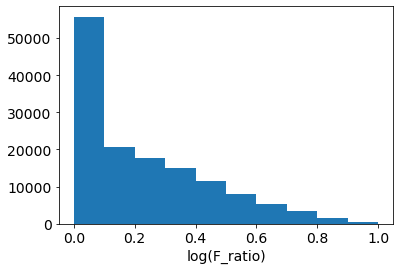

In [126]:
plt.hist(model_cube_sf_agn[-1]);
plt.xlabel('log(F_ratio)');

In [205]:
f_lo = 0.1
f_hi = 0.5
idx_lo = (model_cube_sf_agn[-1] < f_lo) & (model_cube_sf_agn[1] > 8.5)
idx_hi = (model_cube_sf_agn[-1] > f_hi) & (model_cube_sf_agn[1] > 8.5)
Z_model_sf_lo = Z_model_sf[idx_lo]
M_model_sf_lo = M_model_sf[idx_lo]
Z_model_sf_hi = Z_model_sf[idx_hi]
M_model_sf_hi = M_model_sf[idx_hi]
AGN_model_sf_lo = AGN_model_sf[idx_lo]
AGN_model_sf_hi = AGN_model_sf[idx_hi]

In [206]:
A_combined_model_sf_lo_w_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn[:,idx_lo])
T_combined_model_sf_lo_w_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn[:,idx_lo])

In [207]:
A_combined_model_sf_lo_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf[:,idx_lo])
T_combined_model_sf_lo_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf[:,idx_lo])

In [208]:
A_combined_model_sf_hi_w_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf_agn[:,idx_hi])
T_combined_model_sf_hi_w_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf_agn[:,idx_hi])

In [209]:
A_combined_model_sf_hi_agn = model_A_or_Tdust(vA_sf_agn, model_cube_sf[:,idx_hi])
T_combined_model_sf_hi_agn = model_A_or_Tdust(vT_sf_agn, model_cube_sf[:,idx_hi])

In [210]:
combined_theta_model_lo_w_agn = A_combined_model_sf_lo_w_agn, np.array(T_combined_model_sf_lo_w_agn / (1+Z_model_sf_lo))

In [211]:
combined_theta_model_lo_agn = A_combined_model_sf_lo_agn, np.array(T_combined_model_sf_lo_agn / (1+Z_model_sf_lo))

In [212]:
combined_theta_model_hi_w_agn = A_combined_model_sf_hi_w_agn, np.array(T_combined_model_sf_hi_w_agn / (1+Z_model_sf_hi))

In [213]:
combined_theta_model_hi_agn = A_combined_model_sf_hi_agn, np.array(T_combined_model_sf_hi_agn / (1+Z_model_sf_hi))

In [214]:
LIR_model_sf_lo_w_agn = fast_LIR(simstack_object, combined_theta_model_lo_w_agn, Z_model_sf_lo)

In [215]:
LIR_model_sf_lo_agn = fast_LIR(simstack_object, combined_theta_model_lo_agn, Z_model_sf_lo)

In [216]:
LIR_model_sf_hi_w_agn = fast_LIR(simstack_object, combined_theta_model_hi_w_agn, Z_model_sf_hi)

In [217]:
LIR_model_sf_hi_agn = fast_LIR(simstack_object, combined_theta_model_hi_agn, Z_model_sf_hi)

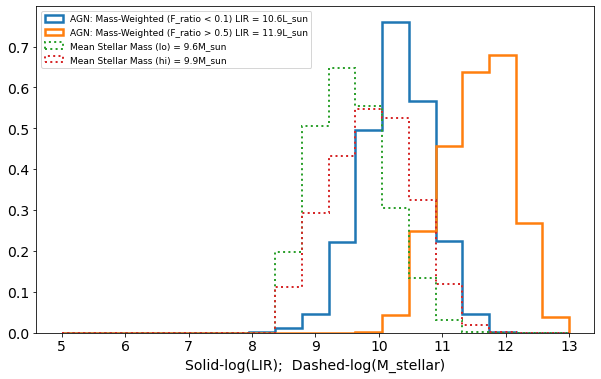

In [218]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
bins_lir = np.linspace(5,13,20)
wlo=None #M_model_sf_lo 
whi=None #M_model_sf_hi 

plt.hist(np.log10(LIR_model_sf_lo_w_agn), bins=bins_lir, ls='-', weights=wlo, density=True,histtype='step',lw=2.5,label='AGN: Mass-Weighted (F_ratio < {0}) LIR = {1:0.1f}L_sun'.format(f_lo,np.log10(np.mean(LIR_model_sf_lo_w_agn))) );
plt.hist(np.log10(LIR_model_sf_hi_w_agn), bins=bins_lir, ls='-', weights=whi, density=True,histtype='step',lw=2.5,label='AGN: Mass-Weighted (F_ratio > {0}) LIR = {1:0.1f}L_sun'.format(f_hi,np.log10(np.mean(LIR_model_sf_hi_w_agn))) );

plt.hist(M_model_sf_lo, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (lo) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_lo)));
plt.hist(M_model_sf_hi, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (hi) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_hi)));

plt.xlabel('Solid-log(LIR);  Dashed-log(M_stellar)')
plt.legend(loc='upper left',fontsize=9);

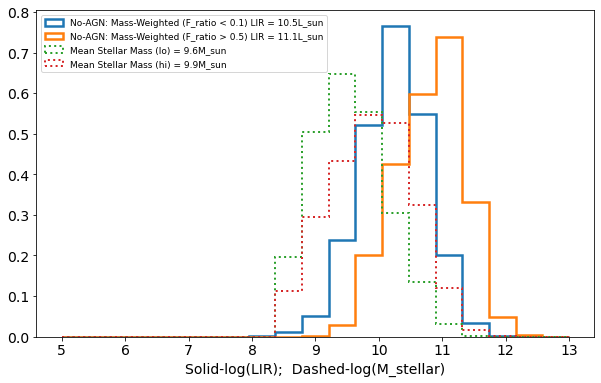

In [219]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
bins_lir = np.linspace(5,13,20)
wlo=None #M_model_sf_lo 
whi=None #M_model_sf_hi 

plt.hist(np.log10(LIR_model_sf_lo_agn), bins=bins_lir, ls='-', weights=wlo, density=True,histtype='step',lw=2.5,label='No-AGN: Mass-Weighted (F_ratio < {0}) LIR = {1:0.1f}L_sun'.format(f_lo,np.log10(np.mean(LIR_model_sf_lo_agn))) );
plt.hist(np.log10(LIR_model_sf_hi_agn), bins=bins_lir, ls='-', weights=whi, density=True,histtype='step',lw=2.5,label='No-AGN: Mass-Weighted (F_ratio > {0}) LIR = {1:0.1f}L_sun'.format(f_hi,np.log10(np.mean(LIR_model_sf_hi_agn))) );

plt.hist(M_model_sf_lo, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (lo) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_lo)));
plt.hist(M_model_sf_hi, bins=bins_lir, ls=':',weights=None, density=True, histtype='step',lw=2,label='Mean Stellar Mass (hi) = {0:0.1f}M_sun'.format(np.mean(M_model_sf_hi)));

plt.xlabel('Solid-log(LIR);  Dashed-log(M_stellar)')
plt.legend(loc='upper left',fontsize=9);

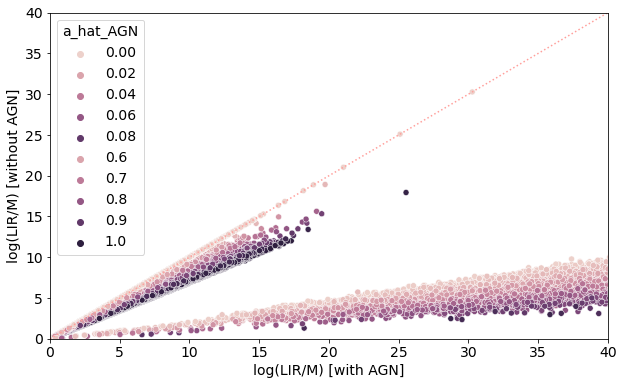

In [142]:
fig, axs = plt.subplots(1, 1, figsize=(10,6))
sns.scatterplot(LIR_model_sf_lo_w_agn/10**M_model_sf_lo, LIR_model_sf_lo_agn/10**M_model_sf_lo, hue=AGN_model_sf_lo)
sns.scatterplot(LIR_model_sf_hi_w_agn/10**M_model_sf_hi, LIR_model_sf_hi_agn/10**M_model_sf_hi, hue=AGN_model_sf_hi)
xlim=40
plt.xlim([0,xlim]);
plt.ylim([0,xlim]);
plt.xlabel('log(LIR/M) [with AGN]')
plt.ylabel('log(LIR/M) [without AGN]')
axs.plot([0,xlim],[0,xlim],'r:');


## Now make maps from fits

In [143]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf_agn,T_combined_model_sf_agn/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt_agn,T_combined_model_qt_agn/np.array(1+Z_model_qt))

In [144]:
outmap_dict={}
def write_fits(self,
               mapin,
               map_name,
               path_map=r'C:\Users\viero\Desktop', 
               prefix='model_',
               overwrite=True, 
               show=False):
    
    if show:
        plt.imshow(model_250)

    map_object = self.maps_dict[map_name]
    #path_map = r'D:\maps\cutouts\layers'
    name_map = prefix+str(map_name)+'.fits'

    hd = map_object['header']
    fwhm = map_object['fwhm']
    pix = map_object['pixel_size']
    kern = gauss_kern(fwhm, np.floor(fwhm * 10) / pix, pix)
    tmap = smooth_psf(mapin, kern)
    
    ind_zero = abs(tmap) < 1e-10
    ind_non_zero = mapin != 0
    smap = tmap
    smap -= np.mean(smap[ind_non_zero])
    #smap[ind_zero]=0

    hdu = fits.PrimaryHDU(smap, header=hd)
    hdul = fits.HDUList([hdu])
    hdul.writeto(os.path.join(path_map, name_map),overwrite=overwrite)
    outmap_dict[name_map]=smap
    print('{0} written to {1}'.format(name_map,path_map))

In [145]:
for map_key in simmap_dict:
    #write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='mapfit_'+prefix)    
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_and_qt2_convolved_mapfit_z_Trf'+prefix)

sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_mips_24.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_pacs_green.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_pacs_red.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_psw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_plw.fits written to C:\Users\viero\Desktop
sfg_and_qt2_convolved_mapfit_z_TrfAhat__A_gt_n35p5_scuba_850.fits written to C:\Users\viero\Desktop


In [297]:
simmap_dict = {}
for map_key in simstack_maps_object.maps_dict:
    map_object = simstack_maps_object.maps_dict[map_key]
    map_lambda = map_object['wavelength']
    map_nu = c * 1.e6/map_lambda
    x, y = get_x_y_from_ra_dec(map_object, ra_model_sf, dec_model_sf)
    simmap_dict[map_key] = np.zeros_like(map_object['map'])
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_sf_three,T_combined_model_sf_three/np.array(1+Z_model_sf))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_qt, dec_model_qt)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_qt_three,T_combined_model_qt_three/np.array(1+Z_model_qt))
    
    x, y = get_x_y_from_ra_dec(map_object, ra_model_three, dec_model_three)
    simmap_dict[map_key][x,y] += get_map_flux_mJy(np.array([map_nu]),A_combined_model_agn_three,T_combined_model_agn_three/np.array(1+Z_model_three))

In [298]:
for map_key in simmap_dict:
    #write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='mapfit_'+prefix)    
    write_fits(simstack_maps_object, simmap_dict[map_key], map_key, prefix='sfg_qt_agn_convolved_mapfit_z_Trf'+prefix)

sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_mips_24.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_pacs_green.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_pacs_red.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_psw.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_pmw.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_spire_plw.fits written to C:\Users\viero\Desktop
sfg_qt_agn_convolved_mapfit_z_TrfAhat__A_gt_n35p5_scuba_850.fits written to C:\Users\viero\Desktop
